# CSEP tests 

This notebook describes the theory of each of the forecast tests included in pyCSEP with application to an example forecast. You will find information on the aims of each test, the theory behind the test, how the tests are applied in practice and how forecasts are 'scored' given the test results, as well as key references. The code required to run in each test and a description of how to interpret the test results is also included.

In [9]:
import csep
from csep.core import regions, catalog_evaluations, poisson_evaluations as poisson
#from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, comcat, plots, readers

## Grid-based tests

These tests are for grid-based forecasts constructed as per the RELM experiments (Schorlemmer et al, 2007), where rates are provided in cells of a forecast. In this case, rates are specified in time-space-magnitude cells covering the region of interest. The region $\boldsymbol{R}$ is then the product of the spatial rate $\boldsymbol{S}$ and the binned magnitude rate $\boldsymbol{M}$. 
$$ \boldsymbol{R} = \boldsymbol{M} \times \boldsymbol{S} $$

A forecast $\boldsymbol{\Lambda}$ can then be fully specified as the expected number of events in each space-magnitude bin ($m_i, s_j$) covering the region $\boldsymbol{R}$ and therefore can be written as 
$$ \boldsymbol{\Lambda} = \{ \lambda_{m_i, s_j}| m_i \in \boldsymbol{M}, s_j \in \boldsymbol{S} \} $$
where $\lambda_{m_i, s_j}$ is the expected rate of events in magnitude bin $m_i$ and spatial bin $s_j$.

The observed catalogue of events $\boldsymbol{\Omega}$ that we wish to test the forecast against is similarly discretised into the same space-magnitude bins such that it can be described as
$$ \boldsymbol{\Omega} = \{ \omega_{m_i, s_j}| m_i \in \boldsymbol{M}, s_j \in \boldsymbol{S} \} $$
where $ \omega_{m_i, s_j}$ is the observed number of events in spatial cell $s_j$ and magnitude bin $m_i$.

The magnitude bins are specified in the forecast: typically these are in 0.1 increments and this is the case in the examples we use here. The range of magnitude bins is determined by the forecast, or the forecast specification in the case of CSEP experiments where the spatial region is also predetermined for consistency across competing models (e.g. Schorlemmer et al 2007; Schorlemmer et al, 2010a). These examples use the Helmstetter et al (2007) smoothed seismicity forecast (including aftershocks), testing over a 5 year period between 2010 and 2015.

In [10]:
## Set up experiment parameters
start_date = time_utils.strptime_to_utc_datetime('2010-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2015-01-01 00:00:00.0')

## Loads from the PyCSEP package
Helmstetter = csep.load_gridded_forecast(datasets.helmstetter_aftershock_fname,
                                      start_date=start_date,
                                      end_date=end_date,
                                      name='helmstetter_aftershock')
## Set up evaluation catalog
catalog = csep.query_comcat(Helmstetter.start_time, Helmstetter.end_time,
                            min_magnitude=Helmstetter.min_magnitude)

## Filter evaluation catalog
catalog = catalog.filter_spatial(Helmstetter.region)

Fetched ComCat catalog in 24.800796031951904 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 2010-01-10 00:27:39.320000+00:00
End Date: 2014-08-24 10:20:44.070000+00:00
Min Latitude: 31.9788333 and Max Latitude: 41.1431667
Min Longitude: -125.3308333 and Max Longitude: -115.0481667
Min Magnitude: 4.96
Found 24 events in the ComCat catalog.


### Consistency tests

The consistency tests aim to whether observations are consistent with the forecast assuming that the forecast is 'true'. These tests were developed across a range of experiments and publications (Schorlemmer et al, 2007; Zechar et al 2010; Werner et al, 2011), building on previous tests or ideas about how tests should be constructed. The consistency tests are all based on the likelihood of observing the catalogue (actual recorded events) given the specified forecast, which is given as rate $\lambda$ in each cell. The total likelihood is the joint-likelihood of observing the events in each individual bin given the specified forecast rate $\lambda$ in each bin. We can write this as:
$$ Pr(\omega_1 | \lambda_1) Pr(\omega_2 | \lambda_2)...Pr(\omega_n | \lambda_n) = \prod_{m_i , s_j \in \boldsymbol{R}} f_{m_i, s_j}(\omega(m_i, s_j))$$
where $f_{m_i, s_j}$ specifies the probability distribution in each space-magnitude bin. In these tests, we assume this probability distribution is Poisson in nature, meaning it follows a Poisson distribution where the probability of an event occurring is independent of the time since the last event and events occur at a rate $\lambda$.


We choose to use the joint log-likelihood in order to sum log-likelihoods rather than multiply the likelihoods, so the likelihood can be written as
$$ L(\boldsymbol{\Omega} | \boldsymbol{\Lambda}) = \sum_{m_i , s_j \in \boldsymbol{R}} log(f_{m_i, s_j}(\omega(m_i, s_j)) $$
This says that the likelihood of the observations ($\boldsymbol{\Omega}$) given the forecast $\boldsymbol{\Lambda}$ is the sum over all space-magnitude bins of the log probabilities in individual cells of the forecast.


When a forecast is Poisson, it's likelihood follows a Poisson likelihood and the log-likelihood is then
$$ L(\boldsymbol{\Omega} | \boldsymbol{\Lambda}) = \sum_{m_i , s_j \in \boldsymbol{R}} -\lambda(m_i, s_j) + \omega(m_i, s_j)\log(\lambda(m_i, s_j)) - log(\omega(m_i, s_j)!) $$

where $\lambda(m_i, s_j)$ and $\omega(m_i, s_j)$ are the forecast rates and observed counts in cell $m_i, s_j$ respectively, so we can calculate the likelihood directly given the forecast and discretised observations.

<b> Simulation approach </b>  
To carry out these tests in practice, a simulation based approach is often used to account for uncertainty in the forecast. In the pyCSEP package, as in the original CSEP tests, this simulation is carried out using the cumulative probability density in each bin, which we shall call $F_{m_is_j}$ for the cumulative probability density in cell $m_i, s_j$. The simulation approach then works as follows:

* For each forecast bin, draw a random number $z$ from a uniform distribution between 0 and 1
* Calculate the number of events for this bin by calculating the inverse cumulative density distribution at this point $F^{-1}_{m_i, s_j}(z)$
* Iterate over all bins to generate a catalog consistent with the forecast

For each of these tests, we can plot the distribution of likelihoods of simulated catalogs relative to the observations using the `plots.plot_poisson_consistency_test` function. We can also calculate a quantile score to decide if a model passes or fails an individual test based on the location of the observations within the tails of the foreast distribution and a selected level of sensitivity. The number of simulations can be supplied to the Poisson consistency test functions using the `num_simulations` argument: for best results we would suggest 100 000 simulations to ensure convergence.

#### <b>L-test</b>

<b>Aim:</b> Evaluate the likelihood of observed events given the provided forecast - this is a joint likelihood that includes the number, spatial distribution and magnitude.
    
<b>Method:</b> The L-test is one of the original forecast tests described in Schorlemmer et al, 2007. The likelihood of the observation given the model is described by a Poisson likelihood function in each cell and the total joint likelihood described by the product over all bins, or the sum of the log-likelihoods (see above, or Zechar 2011 for more details). 

By simulating from the forecast as described above, we generate a set of simulated catalogs $\{\hat{\boldsymbol{\Omega}}\}$ where each catalogue can be written as
$$\hat{\boldsymbol{\Omega}}_x =\{ \hat{\omega}_x(m_i, s_j)|(m_i, s_j) \in \boldsymbol{R}\}$$
and $ \hat{\omega}_x(m_i, s_j)$ is the number of simulated earthquakes in cell $m_i, s_j$ of (simulated) catalog $x$.

We then compute the joint log-likelihood for each simulated catalogue $\hat{L}_x = L(\hat{\Omega}_x|\Lambda)$, so the joint log-likelihood for each simulated catalogue given the forecast, to give us a set of log-likelihoods $\{\hat{\boldsymbol{L}}\}$ that represents the range of log-likelihoods consistent with the forecast.   
We then compare our simulated log-likelihoods with the observed log-likelihood $L_{obs} = L(\boldsymbol{\Omega}|\boldsymbol{\Lambda})$: if the  observed log-likelihood falls within the distribution of the simulated log-likelihoods then the forecast is consistent with observations.

The quantile score is then defined by the fraction of simulated joint log-likelihoods less than or equal to the observed.
$$\gamma = \frac{ |\{ \hat{L}_x | \hat{L}_x \le L_{obs}\} |}{|\{ \hat{\boldsymbol{L}} \}|}$$


Whether a forecast can be said to pass a forecast depends on the significance level chosen for the testing process. The quantile score explicitly tells us something about the significance of the result: the observation is inconsistent with the forecast with $100(1-\gamma)\%$ confidence (Zechar, 2011). Low $\gamma$ values demonstrate that the observed likelihood score is less than most of the simulated catalogs. The L-Test is generally considered to be a one-sided test: values which are too small are ruled inconsistent with the forecast, but very large values may not necessarily be inconsistent with the forecast and additional testing should be used to further clarify this (Schorlemmer et al, 2007). Different implementations of CSEP testing have used different sensitivity values. Schorlemmer et al (2010b) consider $\gamma \lt 0.05$ while the implementation in the Italian CSEP testing experiment uses 0.01 (Taroni et al, 2018).  

<b> pyCSEP implementation </b>

The pyCSEP tests takes the forecast and catalog and returns the test distribution, observed statistic and quantile score, which can be accessed from the `likelihood_test_result` object. We can pass this directly to the plotting function, specifying that the test should be one-sided.

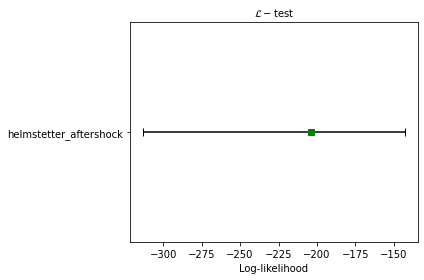

In [16]:
likelihood_test_result = poisson.likelihood_test(Helmstetter, catalog)
ax = plots.plot_poisson_consistency_test(
    likelihood_test_result,  
    one_sided_lower=True, 
    plot_args = {'title': r'$\mathcal{L}-\mathrm{test}$', 'xlabel': 'Log-likelihood'}
)

The pyCSEP consistency test shows the resulting $95\%$ range of likelihoods returned by the simulation with the black bar. The observed likelihood score is shown by a green square where the forecast passes the test and a red circle where the observed likelihood is outside the likelihood distribution.

#### <b> CL-test </b>
<b>Aim</b>: The original likelihood test described above gives a result that combines the spatial, magnitude and number components of a forecast. This means that, should a forecast do badly in forecasting the number of events, it will receive a poor L-Test result. The L-test is significantly influenced by the number of events in the forecast. The conditional likelihood or CL-Test was developed  to test the spatial and magnitude performance of a forecast without the influence of the number of events (Werner et al. 2011a, 2011b). 
    
<b>Method</b>  
The CL-test is computed in the same way as the L-test, but with the number of events normalised to the observed catalog $N_{obs}$ during the simulation stage.
The quantile score is then calculated similarly such that
$$\gamma_{CL} = \frac{ |\{ \hat{CL}_x | \hat{CL}_x \le CL_{obs}\} |}{|\{ \hat{\boldsymbol{CL}} \}|}$$


<b>Implementation in pyCSEP</b>

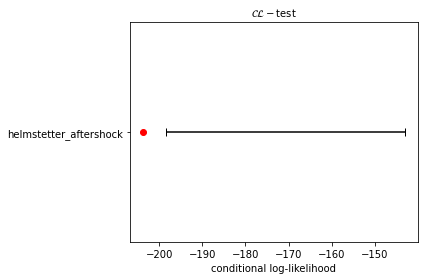

In [24]:
cond_likelihood_test_result = poisson.conditional_likelihood_test(Helmstetter, catalog)
ax = plots.plot_poisson_consistency_test(cond_likelihood_test_result, one_sided_lower=True, plot_args = {'title': r'$\mathcal{CL}-\mathrm{test}$', 'xlabel': 'conditional log-likelihood'})

Again, the $95\%$ confidence range of likelihoods is shown by the black bar, and the symbol reflects the observed conditional-likelihood score. In this case, the observed conditional-likelihood is shown with the red circle, which falls outside the range of likelihoods simulated from the forecast. To understand why the L- and CL-tests give different results, consider the results of the N-test and S-test in the following sections.

#### <b>N-test</b>

<b>Aim</b>: The number or N-test is the most conceptually simple test of a forecast: To test whether the number of observed events is consistent with that of the supplied forecast.

<b>Method</b>: The originial N-test was introduced by Schorlemmer et al (2007) and modified by Zechar et al (2010). The observed number of events is given by:
$$N_{obs} = \sum_{m_i, s_j \in R} \omega(m_i, s_j)$$
Using the simulations described above, the expected number of events is calculated by summing the simulated number of events over all grid cells
$$\hat{N_x} = \sum_{m_i, s_j \in R} \hat{\omega}_x(m_i, s_j) $$
where $\hat{\omega}_x(m_i, s_j)$ is the simulated number of events in catalog $x$ in spatial cell $s_j$ and magnitude cell $m_i$, generating a set of simulated rates $\{ \hat{N} \}$. 


We can then calculate the probability of i) observing at most $N_{obs}$ events and ii) of observing at least $N_{obs}$ events.
These probabilities can be written as:

$$\delta_1 =  \frac{ |\{ \hat{N_x} | \hat{N_x} \le N_{obs}\} |}{|\{ \hat{N} \}|}$$
and
$$\delta_2 =  \frac{ |\{ \hat{N_x} | \hat{N_x} \gt N_{obs}\} |}{|\{ \hat{N} \}|}$$


If a forecast is Poisson, the expected number of events in the forecast follows a Poisson distribution with expectation $N_{fore} = \sum_{m_i, s_j \in R} \lambda(m_i, s_j)$. The cumulative distribution is then a Poisson cumulative distribution:

$$F(x|N_{fore}) = \exp(-N_{fore}) \sum^{x}_{i=0} \frac{(N_{fore})^i}{i!}$$

which can be used directly without the need for simulations. The N-test quantile score is then
$$\delta_1 =  1 - F((N_{obs}-1)|N_{fore})$$ 
and 
$$\delta_2 = F(N_{obs}|N_{fore})$$

The original N-test considered only $\delta_2$ and it's complement $1-\delta_2$, which  effectively tested the probability of at most $N_{obs}$ events and more than $N_{obs}$ events. Very small or very large values (<0.025 or > 0.975 respectively) were considered to be inconsistent with the forecast in Schorlemmer et al (2010). However the approach above aims to test something subtely different, that is at least $N_{obs}$ events and at most $N_obs$ events. Zechar et al (2010a) recommends testing both $\delta_1$ and $\delta_2$ with an effective significance of have the required significance level, so for a required significance level of 0.05, a forecast is consistent if both $\delta_1$ and $\delta_2$ are greater than 0.025. A very small $\delta_1$ suggest the rate is too low while a very low $\delta_2$ suggests a rate which is too high to be consistent with observations.


<b> Implementation in pyCSEP </b> 

pyCSEP uses the Zechar et al (2010) version of the N-test and the cumulative Poisson approach to estimate the range of expected events from the forecasts, so does not implement a simulation in this case. The upper and lower bounds for the test are determined from the cumulative Poisson distribution. `number_test_result.quantile` will return both $\delta_1$ and $\delta_2$ values.

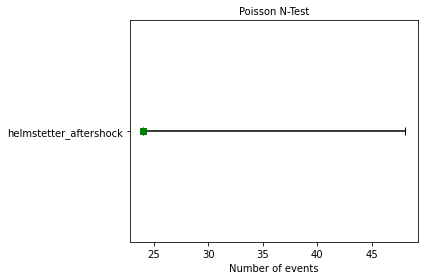

In [28]:
number_test_result = poisson.number_test(Helmstetter, catalog)
ax = plots.plot_poisson_consistency_test(number_test_result, plot_args={'xlabel':'Number of events'})

In this case, the black bar shows the $95\%$ interval for the number of events in the forecast. The actual observed number of events is shown by the green box, which just passes the N-test in this case: the forecast generallly expects more events than are observed in practice, but the observed number falls just within the lower limits of what is expected so the forecast (just!) passes the N-test.

#### <b>M-test</b>

<b>Aim:</b> Establish consistency (or lack thereof) of observed event magnitudes with forecast magnitudes.
    
<b>Method:</b> The M-test is first described in Zechar et al. (2010) and aims to isolate the magnitude component of a forecast. To do this, we sum over the spatial bins and normalise so that the sum of events matches the observations.
$$\hat{\boldsymbol{\Omega}}^m = \big{\{}\omega^{m}(m_i)| m_i \in \boldsymbol{M}\big{\}}$$
where
$$ \omega^m(m_i) = \sum_{s_j \in \boldsymbol{S}} \omega(m_i, s_j) $$
and
$$\boldsymbol{\Lambda}^m = \big{\{} \lambda^m(m_i)| m_i \in \boldsymbol{M} \big{\}} $$
where
$$ \lambda^m(m_i) = \frac{N_{obs}}{N_{fore}}\sum_{s_j \in \boldsymbol{S}} \lambda\big{(}m_i, s_j\big{)}$$

Then we compute the joint log-likelihood as we did for the L-test:
$$ M = L(\boldsymbol{\Omega}^m | \boldsymbol{\Lambda}^m) $$

We then wish to compare this with the distribution of simulated log-likelihoods, this time keep the number of events fixed to $N_{obs}$. Then for each simulated catalogue, $\hat{M}_x = L(\hat{\boldsymbol{\Omega}}^m | \boldsymbol{\Lambda}^m)$


<b>Quantile score: </b>  The final test statistic is again the fraction of observed log likelihoods within the range of the simulated log likelihood values:
$$\kappa =  \frac{ |\{ \hat{M_x} | \hat{M_x} \le M\} |}{|\{ \hat{M} \}|}$$
and the observed magnitudes are inconsistent with the forecast if $\kappa$ is less than the significance level.


<b>pyCSEP implementation</b>

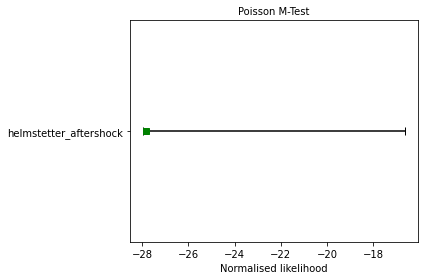

In [26]:
mag_test_result = poisson.magnitude_test(Helmstetter, catalog)
ax = plots.plot_poisson_consistency_test(mag_test_result, one_sided_lower=True, plot_args={'xlabel':'Normalised likelihood'})

In this example, the forecast passes the M-test, demonstrating that the magnitude distribution in the forecast is consistent with observed events. This is shown by the green square marking the joint log-likelihood for the observed events.

#### <b>S-test</b>

<b>Aim:</b> The spatial or S-test aims to establish consistency (or lack thereof) of observed event locations with a forecast. It is originally defined in Zechar et al (2010).
    
<b>Method:</b> Similar to the M-test, but in this case we sum over all magnitude bins.
$$\hat{\boldsymbol{\Omega}^s} = \{\omega^s(s_j)| s_j \in \boldsymbol{S}\}$$
where
$$ \omega^s(s_j) = \sum_{m_i \in \boldsymbol{M}} \omega(m_i, s_j) $$
and
$$\boldsymbol{\Lambda}^s = \{ \lambda^s(s_j)| s_j \in \boldsymbol{S} \} $$
where
$$ \lambda^s(s_j) = \frac{N_{obs}}{N_{fore}}\sum_{m_i \in M} \lambda(m_i, s_j)$$

Then we compute the joint log-likelihood as we did for the L-test or the M-test:
$$ S = L(\boldsymbol{\Omega}^s | \boldsymbol{\Lambda}^s) $$

We then wish to compare this with the distribution of simulated log-likelihoods, this time keeping the number of events fixed to $N_{obs}$. Then for each simulated catalogue, $\hat{S}_x = L(\hat{\boldsymbol{\Omega}}^s | \boldsymbol{\Lambda}^s)$

The final test statistic is again the fraction of observed log likelihoods within the range of the simulated log likelihood values:
$$\zeta =  \frac{ |\{ \hat{S_x} | \hat{S_x} \le S\} |}{|\{ \hat{S} \}|}$$
and again the distinction between a forecast passing or failing the test depends on our significance level.

<b> pyCSEP implementation </b>

The S-test is again a one-sided test, so we specify this when plotting the result.

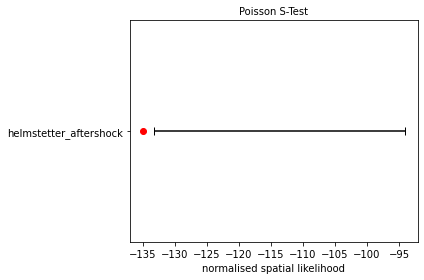

In [31]:
spatial_test_result = poisson.spatial_test(Helmstetter, catalog)
ax = plots.plot_poisson_consistency_test(spatial_test_result, one_sided_lower=True, plot_args = {'xlabel':'normalised spatial likelihood'})

The Helmstetter model fails the S-test as the observed spatial likelihood falls in the tail of the simulated likelihood distribution. Again this is shown by a coloured symbol which highlights whether the forecast model passes or fails the test.

### Forecast comparison tests

The consistency tests above check whether a forecast is consistent with observations, but do not provide a straightforward way to compare two different forecasts. A few suggestions for this focus on the information gain of one forecast relative to another (Harte and Vere-Jones 2005, Imoto and Hurukawa, 2006, Imoto and Rhoades, 2010, Rhoades et al 2011). The T-test and W-test implementations for forecast comparison described here are first described in Rhoades et al, 2011.

The information gain per earthquake of model A compared to model B is defined by  $I_{N}(A, B) = R/N$ where R is the rate-corrected log-likelihood ratio of models A and B gven by 
$$ R = \sum_{k=1}^{N}\big{(}\log\lambda_A(i_k) - \log \lambda_B(i_k)\big{)} - \big{(}\hat{N}_A - \hat{N}_B\big{)}$$ 
If we set $X_i=\log\lambda_A(k_i)$ and $Y_i=\log\lambda_B(k_i)$ then we can define the information gain per earthquake as
$$I_N(A, B) = \frac{1}{N}\sum^N_{i=1}\big{(}X_i - Y_i\big{)} - \frac{\hat{N}_A - \hat{N}_B}{N}$$
If $I(A, B)$ differs significantly from 0, the model with the lower likelihood can be rejected in favour of the other.

<b> T-test </b>  
If $X_i - Y_i$ are independent amd come from the same normal population with mean $\mu$ then we can use the classic paired T-test to evaluate the null hypothesis that $\mu = (\hat{N}_A - \hat{N}_B)/N$ against the alternative hypothesis $\mu \ne (\hat{N}_A - \hat{N}_B)/N$.
To implement this, we let $s$ denote the sample variance of $(X_i - Y_i)$ such that
$$ s^2 = \frac{1}{N-1}\sum^N_{i=1}\big{(}X_i - Y_i\big{)}^2 - \frac{1}{N^2 - N}\bigg{(}\sum^N_{i=1}\big{(}X_i - Y_i\big{)}\bigg{)}^2 $$

Under the null hypothesis $T = I_N(A, B)\big{/}\big{(}s/\sqrt{N}\big{)}$ has a t-distribution with $N-1$ degrees of freedom and the null hypothesis can be rejected if $|T|$ exceeds a critical value of the $t_{N-1}$ distribution. The confidence intervals for $\mu - (\hat{N}_A - \hat{N}_B)/N$ can then be constructed with the form $I_N(A,B) \pm ts/\sqrt{N}$ where t is the appropriate quantile of the $t_{N-1}$ distribution.

<b> W-test </b>  
An alternative to the T-test is the Wilcoxan signed-rank test or W-test. This is a non-parameteric alternative to the T-test which can be used if we do not feel the assumption of normally distributed differences in $X_i - Y_i$ is valid. This assumption might b particularly poor when we have small sample sizes. The W-test instead depends on the (weaker) assumption that $X_i - Y_i$ is symmetric and tests whether the meadian of $X_i - Y_i$ is equal to $(\hat{N}_A - \hat{N}_B)/N$. The W-test is less powerful than the T-test for normally distributed differences and cannot reject the null hypothesis (with $95\%$ confidence) for very small sample sizes ($N \leq 5$).

The T-test becomes more accurate as $N \rightarrow \infty$ due to the central limit theorem and therefore the T-test is considered dependable for large $N$. Where $N$ is small, a model might only be considered more informative if both the T- and W-test results agree.

<b>Implementation in pyCSEP</b>   
The T-test and W-tests are implemented in pyCSEP as below.


IndexError: index 1 is out of bounds for axis 0 with size 1

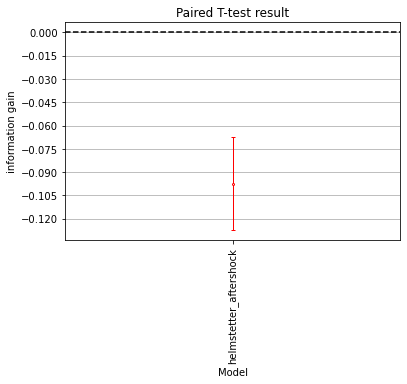

In [36]:
Helmstetter_MS = csep.load_gridded_forecast(datasets.helmstetter_mainshock_fname,
                                              name ="Helmstetter Mainshock")

t_test = poisson.paired_t_test( Helmstetter, Helmstetter_MS, catalog)
w_test = poisson.w_test(Helmstetter, Helmstetter_MS, catalog)
comp_args = {'title': 'Paired T-test result',
             'ylabel': 'information gain',
             'xlabel': 'Model'}

ax = plots.plot_comparison_test([t_test], plot_args= comp_args)

The first argument to the `paired_t_test` function is taken as model B and the second as our basline model, or model A. When plotting the result, the horizontal dashed line indicates the performance of model A and the vertical bar shows the confidence bars for the information gain $I_N(A, B)$ associated with model B relative to model A. In this case, model B does not show significant information gain over model A, so is coloured red to highlight this.

## Catalog-based forecast tests

As an alternative to the grid-based models, the catalog-based tests are designed to better evaluate forecasts which are overdispersed relaative to a Poisson distribution. Further, they allow modellers to capture more of the uncertainty in their models than the traditional grid-based approach. Specifying simulated catalogs removes the need to simulate from a Poisson distribution: earthquake forecasts are often overdispersed due to spatio-temporal clustering, but models with overdispersion are more likely to be rejected by the original, Poisson-based CSEP tests (Werner et al, 2011a). In the catalog-based forecast tests, forecasts are specified as a set of catalogs generated from the forecast model itself by the forecaster. This allows for a broader range of forecast models, for example those generate from earthquake simulator models. The distribution of realisations is then compared with observations, similar to in the grid-based case.  These tests were developed by Savran et al 2020, who applied them to test forecasts following the 2019 Ridgecrest earthquake in Southern California.

Again we begin by defining a region $\boldsymbol{R}$ as a function of some magnitude range $\boldsymbol{M}$, spatial domain $\boldsymbol{S}$ and time period $\boldsymbol{T}$
$$ \boldsymbol{R} = \boldsymbol{M} \times \boldsymbol{S} \times \boldsymbol{T}$$

An earthquake $e$ can be described by a magnitude $m_i$ at some location $s_j$ and time $t_k$.A catalog is simply a collection of earthquakes, such that the observed catalog can be written as
$$\Omega = \big{\{}e_n \big{|} n= 1...N_{obs}; e_n \in \boldsymbol{R} \big{\}}$$
This is our testing catalog, which is made up of observed events.

A forecast is specified as a collection of synthetic catalogs containing events $\hat{e}_{nj}$ in domain $\boldsymbol{R}$

$$ \boldsymbol{\Lambda} \equiv \Lambda_j = \{\hat{e}_{nj} | n = 1... N_j, j= 1....J ;\hat{e}_{nj} \in \boldsymbol{R} \} $$
That is, a forecast consists of $J$ simulated catalogs each containing $N_j$ events, described in time, space and magnitude such that $\hat{e}_{nj}$ describes the $n$th synthetic event in the $j$th synthetic catalog $\Lambda_j$

When using simulated forecasts in pyCSEP, we must first explicitly specify the forecast region by specifying the spatial domain and magnitude regions as below. This is necessary for some of the tests, as you will see below. The examples in this section are catalog-based forecast simulations for the Landers earthquake and aftershock sequence generated using UCERF3-ETAS (Field et al, 2017).

In [38]:
start_time = time_utils.strptime_to_utc_datetime("1992-06-28 11:57:34.14")
end_time = time_utils.strptime_to_utc_datetime("1992-07-28 11:57:34.14")

# Magnitude bins properties
min_mw = 4.95
max_mw = 8.95
dmw = 0.1

# Create space and magnitude regions. The forecast is already filtered in space and magnitude
magnitudes = regions.magnitude_bins(min_mw, max_mw, dmw)
region = regions.california_relm_region()

# Bind region information to the forecast (this will be used for binning of the catalogs)

space_magnitude_region = regions.create_space_magnitude_region(region, magnitudes)

# Load forecast
forecast = csep.load_catalog_forecast(datasets.ucerf3_ascii_format_landers_fname,
                                      start_time = start_time, end_time = end_time,
                                      region = space_magnitude_region)

forecast.filters = [f'origin_time >= {forecast.start_epoch}', f'origin_time < {forecast.end_epoch}']
_ = forecast.get_expected_rates(verbose=False)
# Obtain Comcat catalog and filter to region.
comcat_catalog = csep.query_comcat(start_time, end_time, min_magnitude=forecast.min_magnitude)

# Filter observed catalog using the same region as the forecast
comcat_catalog = comcat_catalog.filter_spatial(forecast.region)



Fetched ComCat catalog in 0.726801872253418 seconds.

Downloaded catalog from ComCat with following parameters
Start Date: 1992-06-28 11:57:34.130000+00:00
End Date: 1992-07-24 18:14:36.250000+00:00
Min Latitude: 33.901 and Max Latitude: 36.705
Min Longitude: -118.067 and Max Longitude: -116.285
Min Magnitude: 4.95
Found 20 events in the ComCat catalog.


#### <b> Number Test </b>  
    
<b>Aim</b>: As above, the number test aims to evaluate if the number of observed events is consistent with the forecast.

<b>Method</b>: The observed statistic in this case is given by $N_{obs} = |\Omega|$, which is simply the number of events in the observed catalog.
To build the test distribution from the forecast, we simply count the number of events in each simulated catalog.
$$ N_{j} = |\Lambda_c|; j = 1...J$$

As in the gridded test above, we can then evaluate the probabilities of at least and at most N events, in this case using the empirical cumlative distribution function of $F_N$:
$$\delta_1 = P(N_j \geq N_{obs}) = 1 - F_N(N_{obs}-1)$$ 
and 
$$\delta_2 = P(N_j \leq N_{obs}) = F_N(N_{obs})$$

<b> Implementation in pyCSEP </b>


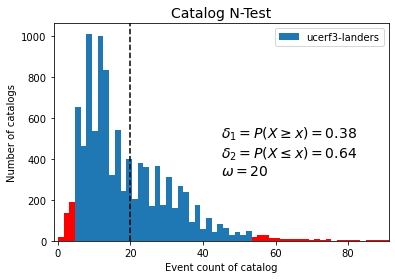

In [39]:
number_test_result = catalog_evaluations.number_test(forecast, comcat_catalog)
ax = number_test_result.plot()

Plotting the number test result of a simulated catalog forecast displays a histogram of the numbers of events $\hat{N}_j$ in each simulated catalog $j$, which makes up the test distribution. The test statistic is shown by the dashed line - in this case it is the number of observed events in the catalog $N_{obs}$. 

#### <b> Magnitude Test </b>
<b>Aim</b>: Once again, the magnitude test aims to test the consistency of the observed frequency-magnitude distribution with that in the simulated catalogs that make up the forecast.

<b>Method:</b> The catalog-based magnitude test is implemented quite differently to the grid-based equivalent. We first define the union catalog $\Lambda_U$ as the union of all simulated catalogs in the forecast. Formally:
$$ \Lambda_U = \{ \lambda_1 \cup \lambda_2 \cup ... \cup \lambda_j \}$$
so that the union catalog contains all events across all simulated catalogs for a total of $N_U = \sum_{j=1}^{J} \big{|}\lambda_j\big{|}$ events.  
We then compute the following histograms discretised to the magnitude range and stepsize (specified earlier for pyCSEP):
1. the histogram of the union catalog magnitudes $\Lambda_U^{(m)}$
2. Histograms of magnitudes in each of the individual simulated catalogs $\lambda_j^{(m)}$
3. the histogram of the observed catalog magnitudes $\Omega^{(m)}$  

The histograms are normalised so that the total number of events across all bins is equal to the observed number.

The observed statistic is then calculated as the sum of squared logarithmic residuals between the normalised observed magnitudes and the union histograms
$$d_{obs}= \sum_{k}\Bigg(\log\Bigg[\frac{N_{obs}}{N_U} \Lambda_U^{(m)}(k) + 1\Bigg]- \log\Big[\Omega^{(m)}(k) + 1\Big]\Bigg)^2$$
where $\Lambda_U^{(m)}(k)$ and $\Omega^{(m)}(k) $ represent the count in the $k$th bin of the magnitude-frequency distribution in the union and observed catalogs respectively. We add unity to each bin to avoid $\log(0)$.

We then build the test distribution from the catalogs in $\boldsymbol{\Lambda}$:
$$ D_j =  \sum_{k}\Bigg(\log\Bigg[\frac{N_{obs}}{N_U} \Lambda_U^{(m)}(k) + 1\Bigg]- \log\Bigg[\frac{N_{obs}}{N_j}\Lambda_j^{(m)}(k) + 1\Bigg]\Bigg)^2; j= 1...J$$
where $\lambda_j^{(m)}(k)$ represents the count in the $k$th bin of the magnitude-frequency distribution of the $j$th catalog.

The quantile score can then be calculated using the empirical CDF such that
$$ \gamma_m = F_D(d_{obs})= P(D_j \leq d_{obs})$$

<b> Implementation in pyCSEP </b>  
Hopefully you now see why it was necessary to specify our magnitude range explicitly when we set up the catalog-type testing - we need to makes sure the magnitudes are properly discretised for the model we want to test.

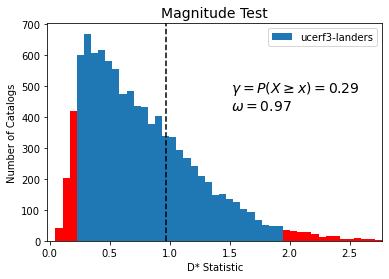

In [18]:
magnitude_test_result = catalog_evaluations.magnitude_test(forecast, comcat_catalog)
ax = magnitude_test_result.plot()

The histogram shows the resulting test distribution with $D^*$ calculated for each simulated catalog as described in the method above. The test statistic $\omega = d_{obs}$ is shown with the dashed horizontal line. The quantile score for this forecast is $\gamma = 0.29$.

#### <b>Pseudo-likelihood test</b>

<b> Aim </b>: The pseudo-likelihood test aims to evaluate the likelihood of a forecast given an observed catalog.

<b> Method </b>: The pseudo-likelihood test has similar aims to the grid-based likelihood test above, but its implementation differs in a few significant ways. Firstly, it does not compute an actual likelihood (hence the name pseudo-likelihood), and instead of aggregating over cells as in the grid-based case, the pseudo-likelihood test aggregates likelihood over target event likelihood scores (so likelihood score per target event, rather than likelihood score per grid cell). The most important difference, however, is that the pseudo-likelihood tests do not use a Poisson likelihood at all, but instead calculate a test distribution of pseudo-likelihoods from the simulated catalogs themselves.

The pseudo-likelihood approach is based on the continuous point process likelihood function. A continuous marked space-time point process can be specified by a conditional intensity function $\lambda(\boldsymbol{e}|H_t)$, in which $H_t$ describes the history of the process in time. The log-likelihood function for any point process in $\boldsymbol{R}$ is given by
$$ L = \sum_{i=1}^{N} \log \lambda(e_i|H_t) - \int_{\boldsymbol{R}}\lambda(\boldsymbol{e}|H_t)d\boldsymbol{R}$$
Not all models will have an explicit likelihood function, so instead we approximate the expectation of $\lambda(e|H_t)$ using the forecast catalogs. The approximate rate density is defined as the conditional expectation given a discretised region $R_d$ of the continuous rate
$$\hat{\lambda}(\boldsymbol{e}|H_t) = E\big[\lambda(\boldsymbol{e}|H_t)|R_d\big]$$
We still regard the model as continuous, but the rate density is approximated within a single cell. This is analogous to the gridded approach where we count the number of events in discrete cells.
The pseudo-loglikelihood is then
$$\hat{L} = \sum_{i=1}^N \log \hat{\lambda}(e_i|H_t) - \int_R \hat{\lambda}(\boldsymbol{e}|H_t) dR $$
and we can write the approximate rate density as
$$\hat{\lambda}(\boldsymbol{e}|H_t) = \sum_M \hat{\lambda}(\boldsymbol{e}|H_t) $$
Where we take the sum over all magnitude bins $M$.

We can calculate observed pseudolikelihood as
$$ \hat{L}_{obs} = \sum_{i=1}^{N_{obs}} \log \hat{\lambda}_s(k_i) - \bar{N} $$
where $\hat{\lambda}_s(k_i)$ is the approximate rate density in the $k$th spatial cell and $k_i$ denotes the spatil cell in which the $i$th event occurs. $\bar{N}$ is the expected number of events in $R_d$.
Similarly, we calculate the test distribution as
$$\hat{L}_{j} = \Bigg[\sum_{i=1}^{N_{j}} \log\hat{\lambda}_s(k_{ij}) - \bar{N}\Bigg]; j = 1....J $$
where $\hat{\lambda}_s(k_{ij})$ describes the approximate rate density of the $i$th event in the $j$th catalog.

We can then calculate the quantile score as
$$ \gamma_L = F_L(\hat{L}_{obs})= P(\hat{L}_j \leq \hat{L}_{obs})$$

<b> Implementation in pyCSEP </b>

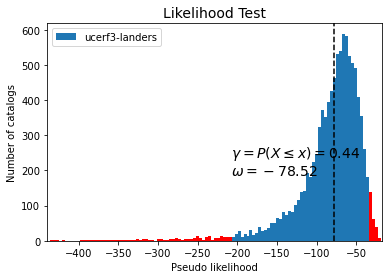

In [19]:
pseudolikelihood_test_result = catalog_evaluations.pseudolikelihood_test(forecast, comcat_catalog)
ax = pseudolikelihood_test_result.plot()

The histogram shows the test distribution of pseudolikelihood as calculated above for each catalog $j$. The dashed vertical line shows the observed statistic $\hat{L}_{obs} = \omega$. It is clear that the observed statistic falls within the test distribution, as reflected in the quantile score of $\gamma_L = 0.44$.

#### <b> Spatial test </b>

<b> Aim</b>: The spatial test again aims to isolate the spatial component of the forecast and test the consistency of spatial rates with observed events.

<b>Method</b> We perform the spatial test in the catalog-based approach in a similar way to the grid-based spatial test approach: by normalising the approximate rate density. In this case, we use the normalisation $\hat{\lambda}_s = \hat{\lambda}_s \big/ \sum_{R} \hat{\lambda}_s$. Then the observed spatial test statistic is calculated as
$$ S_{obs} = \Bigg[\sum_{i=1}^{N_{obs}} \log \hat{\lambda}_s^*(k_i)\Bigg]N_{obs}^{-1}$$
in which $\hat{\lambda}_s^*(k_i)$ is the normalised approximate rate density in the $k$th cell corresponding to the $i$th event in the observed catalog $\Omega$.
Similarly, we define the test distribution using
$$ S_{c} = \bigg[\sum_{i=1}^{N_{j}} \log \hat{\lambda}_s^*(k_{ij})\bigg]N_{j}^{-1}; j= 1...J$$
for each catalog j.
Finally, the quantile score for the spatial test is determined by once again comparing the observed and test distribution statistics:
$$\gamma_s = F_s(\hat{S}_{obs}) = P (\hat{S}_j \leq \hat{S}_{obs})$$

<b> Implementation in pyCSEP </b>

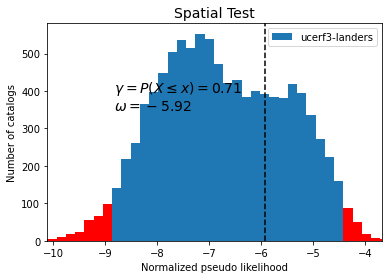

In [40]:
spatial_test_result = catalog_evaluations.spatial_test(forecast, comcat_catalog)
ax = spatial_test_result.plot()

The histogram shows the test distribution of normalised pseduo-likelihood computed for each simulated catalog $j$. The dashed vertical line shows the observed test statistic $s_{obs} = \omega = -5.92$, which is clearly within the test distribution. The quantile score $\gamma_s = 0.71$ is also  printed on the figure by default.

### References
Field, E. H., K. R. Milner, J. L. Hardebeck, M. T. Page, N. J. van der Elst, T. H. Jordan, A. J. Michael, B. E. Shaw, and M. J. Werner (2017). A spatiotemporal clustering model for the third Uniform California Earthquake Rupture Forecast (UCERF3-ETAS): Toward an operational earthquake forecast, Bull. Seismol. Soc. Am. 107, 1049–1081.

Harte, D., and D. Vere-Jones (2005), The entropy score and its uses in earthquake forecasting, Pure Appl. Geophys. 162 , 6-7, 1229-1253, DOI: 10.1007/
s00024-004-2667-2.

Helmstetter, A., Y. Y. Kagan, and D. D. Jackson (2006). Comparison of short-term and time-independent earthquake forecast models for southern California, Bulletin of the Seismological Society of America 96 90-106.

Imoto, M., and N. Hurukawa (2006), Assessing potential seismic activity in Vrancea, Romania, using a stress-release model, Earth Planets Space 58 ,
1511-1514.

Imoto, M., and D.A. Rhoades (2010), Seismicity models of moderate earthquakes in Kanto, Japan utilizing multiple predictive parameters, Pure Appl. Geophys.
167 , 6-7, 831-843, DOI: 10.1007/s00024-010-0066-4.

Rhoades, D.A, D., Schorlemmer, M.C.Gerstenberger, A. Christophersen, J. D. Zechar & M. Imoto (2011) Efficient testing of earthquake forecasting models, Acta Geophysica 59

Savran, W., M. J. Werner, W. Marzocchi, D. Rhoades, D. D. Jackson, K. R. Milner, E. H. Field, and A. J. Michael (2020). Pseudoprospective evaluation of UCERF3-ETAS forecasts during the 2019 Ridgecrest Sequence, Bulletin of the Seismological Society of America.

Schorlemmer, D., and M.C. Gerstenberger (2007), RELM testing center, Seismol. Res. Lett. 78, 30–36.

Schorlemmer, D., M.C. Gerstenberger, S. Wiemer, D.D. Jackson, and D.A. Rhoades (2007), Earthquake likelihood model testing, Seismol. Res. Lett. 78, 17–29.

Schorlemmer, D., A. Christophersen, A. Rovida, F. Mele, M. Stucci and W. Marzocchi (2010a). Setting up an earthquake forecast experiment in Italy, Annals of Geophysics, 53, no.3

Schorlemmer, D., J.D. Zechar, M.J. Werner, E.H. Field, D.D. Jackson, and T.H. Jordan (2010b), First results of the Regional Earthquake Likelihood Models experiment, Pure Appl. Geophys., 167, 8/9, doi:10.1007/s00024-010-0081-5.

M. Taroni, W. Marzocchi, D. Schorlemmer, M. J. Werner, S. Wiemer, J. D. Zechar, L. Heiniger, F. Euchner; Prospective CSEP Evaluation of 1‐Day, 3‐Month, and 5‐Yr Earthquake Forecasts for Italy. Seismological Research Letters 2018;; 89 (4): 1251–1261. doi: https://doi.org/10.1785/0220180031

Werner, M. J., A. Helmstetter, D. D. Jackson, and Y. Y. Kagan (2011a). High-Resolution Long-Term and Short-Term Earthquake Forecasts for California, Bulletin of the Seismological Society of America 101 1630-1648

Werner, M.J. J.D. Zechar, W. Marzocchi, and S. Wiemer (2011b), Retrospective evaluation of the five-year and ten-year CSEP-Italy earthquake forecasts, Annals of Geophysics 53, no. 3, 11–30, doi:10.4401/ag-4840.

Zechar, 2011: Evaluating earthquake predictions and earthquake forecasts: a guide for students and new researchers, CORSSA (http://www.corssa.org/en/articles/theme_6/)

Zechar, J.D., M.C. Gerstenberger, and D.A. Rhoades (2010a), Likelihood-based tests for evaluating space-rate-magnitude forecasts, Bull. Seis. Soc. Am., 100(3), 1184—1195, doi:10.1785/0120090192.

Zechar, J.D., D. Schorlemmer, M. Liukis, J. Yu, F. Euchner, P.J. Maechling, and T.H. Jordan (2010b), The Collaboratory for the Study of Earthquake Predictability perspective on computational earthquake science, Concurr. Comp-Pract. E., doi:10.1002/cpe.1519.

